# We generate 2d ising configurations and train the RBM on that but with only one hidden unit. This seems to not be working.

In [1]:
import sys
import os
sys.path.append('Jerome_scripts_Original/PGM/')
sys.path.append('selfPackages/')
sys.path.append('Jerome_scripts_Original/')
sys.path.append('ffmpeg-3.4.2-32bit-static/')

import numpy as np
import scipy as sc
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import rbm
    import bm
except:
    print 'Compiling cy_utilities first'
    curr_dir = os.getcwd()
    os.chdir('PGM/')
    !python setup.py build_ext --inplace
    print 'Compilation done'
    os.chdir(curr_dir)
    
import pickle
from ising import IsingModel
import estimate_correlations_ising
from sklearn.utils import shuffle
import inlineMovies

In [33]:
#import dill
#dill.dump_session('./data_bruckner/data/notebookData/22_ising2D_oneUnit')

In [2]:
#import dill
#dill.load_session('./data_bruckner/data/notebookData/22_ising2D_oneUnit')

In [3]:
beta_critical = np.log(1+2**0.5)/2
print beta_critical

0.44068679351


In [ ]:
#%%capture capt1
#Supress the output of the cell and save it to capt1

size = 20
N = size**2
beta = 0.2
Num_configs = 100000

#Generate spins using Gibbs Sampling MCMC
BM = bm.BM(N=N,nature='Spin')

#Define Couplings
BM.layer.couplings = ising2dCouplings(BM,size,beta1=beta,beta2=beta,PBC=True)
#print BM.layer.couplings

data = BM.gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=200) # N steps.

#Estimate Correlations for number of MC steps
plt.plot(data.mean(1)[0:10000]);plt.show()

import estimate_correlations_ising
Xcorr = estimate_correlations_ising.spin_autocorr(data,n_max=int(Num_configs*0.1))
plt.plot(Xcorr);plt.show()

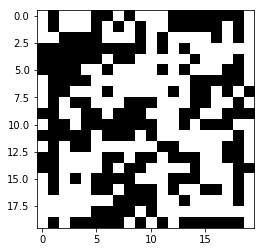

In [22]:
plt.imshow(np.reshape(data[3,:],(size,size)),cmap='binary')

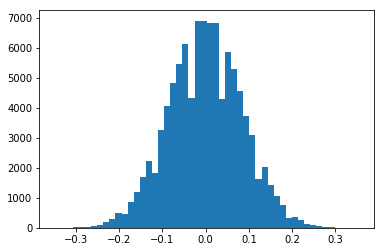

In [28]:
plt.hist(data.mean(1),50);plt.show()

In [24]:
#Train the model
RBM = rbm.RBM(visible = 'Spin', n_v=N, n_h = 1, hidden = 'Spin',zero_field = True)
results = RBM.fit(data,n_iter=20,verbose=0,learning_rate = 0.01,record=['W'],record_interval=100,batch_size=100,N_MC= 20, lr_decay=False,batch_norm=False);

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20


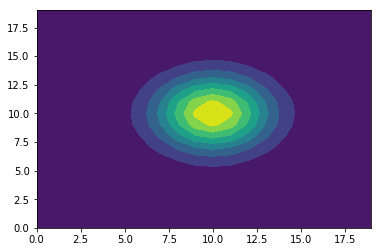

In [4]:
from scipy.stats import multivariate_normal
x = np.linspace(0, size-1, size)
y = np.linspace(0, size-1, size)
x, y = np.meshgrid(x, y)
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal([size/2, size/2], [[size/4, 0], [0,size/4]])
plt.contourf(x, y, 10*rv.pdf(pos))

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 54
Starting epoch 55
Starting epoch 56
S

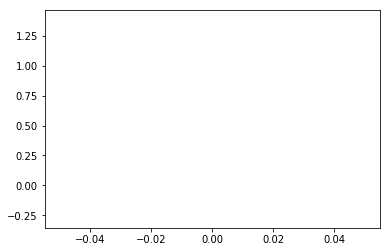

In [5]:
#Train the model starting from a peak solution
RBM = rbm.RBM(visible = 'Spin', n_v=N, n_h = 1, hidden = 'Spin',zero_field = True)
RBM.weights =  [np.ndarray.flatten(40*rv.pdf(pos))]
RBM.weights += 0.1*np.random.randn(N)
plt.plot(RBM.weights)
results = RBM.fit(data,n_iter=100,verbose=0,learning_rate = 0.01,record=['W'],record_interval=100,batch_size=100,N_MC= 20, lr_decay=False,batch_norm=False,init='previous')

In [ ]:
# Reshape the weights array:
weights = np.zeros((np.shape(np.array(results['W']))[1],np.shape(np.array(results['W']))[0],size,size))
weights[0] = np.reshape(np.array(results['W'])[:,0,:],(np.shape(np.array(results['W']))[0],size,size),order='C')
#weights[1] = np.reshape(np.array(results['W'])[:,1,:],(np.shape(np.array(results['W']))[0],size,size),order='C')

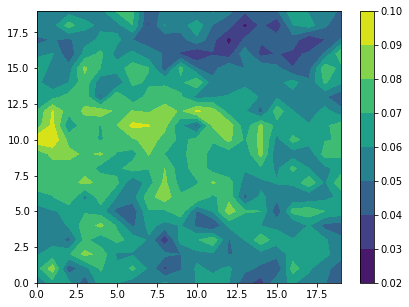

In [36]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.contourf(weights[0,-1])
plt.colorbar()
#plt.subplot(122)
#plt.contourf(weights[1,-1])
#plt.colorbar()

### Track the peak Centres in time (trajectory in the 2D plane):

In [5]:
def ising2dCouplings(BM,size=20,beta1=0.39,beta2=0.39,PBC=False):
    
    BM.layer.couplings =  beta1*(np.eye(N=size**2,k=1) + np.eye(N=size**2,k=-1)) + beta2*(np.eye(N=size**2,k=size) + np.eye(N=size**2,k=-size))
    
    N = size
    
    if PBC is True:
        # Add the couplings of the first row to that of the last row and vice versa:
        for i in np.arange(0,N):
            BM.layer.couplings[i,(size**2)-N+i] = beta2
            BM.layer.couplings[(size**2)-N+i,i] = beta2
        # Remove the couplings of the left most coloumn to that of the last coloumn in its previous row:
        for i in np.arange(0,N*N,N):
            BM.layer.couplings[i,i-1] = 0
            BM.layer.couplings[i-1,i] = 0
        # Add the couplings of the left most column to the right most coloumn:
            BM.layer.couplings[i,i+N-1] = beta1
            BM.layer.couplings[i+N-1,i] = beta1
    
    return BM.layer.couplings